In [1]:
SUBSAMPLE_LENGTH = 300
#more depth = better performance but slower and more memory required
DEPTH = 11
BATCH_SIZE = 60
DEVICE = 'cuda:3'
EPOCHS = 200
#"bsubtilis" or "ecoli"
IMG_SET = "bsubtilis"
#odd number
MAX_NUM_GENES = 13
INCLUDE_POSITION = False
INCLUDE_SEQUENCE = False

import torch
from torch.utils.data import DataLoader
from operon_transformer import operon_transformer, operon_transformer_classifier
from torch.optim import AdamW
from torch.utils.data import DataLoader
from dataloader import OperonLoader
import math
from tqdm import tqdm
import numpy as np

torch.random.manual_seed(42)

val_data = OperonLoader('data.csv',
                        subsample_length=SUBSAMPLE_LENGTH,
                        include_position=INCLUDE_POSITION,
                        include_sequence=INCLUDE_SEQUENCE,
                        max_num_genes=MAX_NUM_GENES,
                        split_key="valid",
                        im_set=IMG_SET,
                        device=DEVICE)

test_data = OperonLoader('data.csv',
                        subsample_length=SUBSAMPLE_LENGTH,
                        include_position=INCLUDE_POSITION,
                        include_sequence=INCLUDE_SEQUENCE,
                        max_num_genes=MAX_NUM_GENES,
                        split_key="test",
                        im_set=IMG_SET,
                        device=DEVICE)

val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)


model = operon_transformer_classifier(
    depth=DEPTH,
    ckpt_path='saved_models/operon_transformer_stable_last.pt',
    max_num_genes=MAX_NUM_GENES,
    alignment_length=SUBSAMPLE_LENGTH,
    include_position=INCLUDE_POSITION,
    include_sequence=INCLUDE_SEQUENCE,
    stable=False,
    attn_dropout=0,
    ff_dropout=0).to(DEVICE)

model.load_state_dict(torch.load('saved_models/stable_operon_transformer_classifier_last.pt'))

model.eval()

preds = []
labels = []

with torch.no_grad():
    for batch in tqdm(val_dataloader):
        msa, score, label = batch
        out = model(msa, score)
        if len(preds) == 0:
            preds = out[0]
            labels = label.T[0]
        else:
            preds = torch.cat((preds, out[0]), dim=0)
            labels = torch.cat((labels, label.T[0]), dim=0)

/home/emaad/cs294-learning_genome_context/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 150/150 [23:20<00:00,  9.33s/it]


In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(labels.cpu(),preds.cpu())

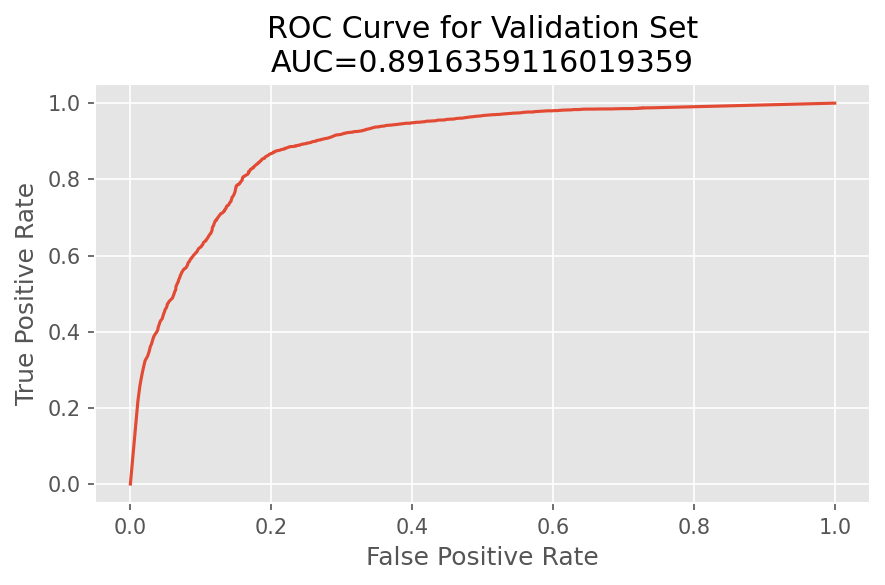

In [37]:
from matplotlib import pyplot as plt

auc = metrics.roc_auc_score(labels.cpu(),preds.cpu())
with plt.style.context('ggplot'):
    plt.figure(dpi=150, clear=True,edgecolor='white', facecolor='white', frameon=False, tight_layout=True)
    plt.title(f'ROC Curve for Validation Set\nAUC={str(auc)}', color='black')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(fpr,tpr)
    plt.savefig('roc_curve.png')
    plt.show()


In [16]:
cutoff = thresholds[np.argmax(tpr-fpr)]

In [22]:
preds_test = []
labels_test = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        msa, score, label = batch
        out = model(msa, score)
        if len(preds_test) == 0:
            preds_test = out[0] >= cutoff
            labels_test = label.T[0]
        else:
            preds_test = torch.cat((preds_test >= cutoff, out[0]), dim=0)
            labels_test = torch.cat((labels_test, label.T[0]), dim=0)

100%|██████████| 12/12 [01:42<00:00,  8.58s/it]


In [30]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(labels_test.long().cpu(), preds_test.long().cpu(), labels=[0, 1]).ravel()

In [32]:
sensitivity = tp/(tp+fn)
precision = tp/(tp+fp)
specificity = tn/(tn+fp)
accuracy = (tp+tn)/(tp+tn+fp+fn)
mcc = (tp*tn-fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
f1 = 2*tp/(2*tp+fp+fn)

print(f'Sensitivity: {sensitivity}')
print(f'Precision: {precision}')
print(f'Specificity: {specificity}')
print(f'Accuracy: {accuracy}')
print(f'MCC: {mcc}')
print(f'F1: {f1}')

Sensitivity: 0.8924731182795699
Precision: 0.8668407310704961
Specificity: 0.8311258278145696
Accuracy: 0.8649851632047477
MCC: 0.7264855585454512
F1: 0.8794701986754967


In [34]:
cutoff

0.757

In [38]:
len(test_data)

674